In [35]:
#### SIDHARTH V.    18EX20029

%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import sys


import matplotlib.pyplot as plt
import time

print("a")

a


In [36]:
apply_transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 64 # change according to system specs



trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader
                                      

In [37]:
trainLoader

In [38]:
#Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(784, 500)
        self.lin2 = nn.Linear(500, 500)
        self.lin3gauss = nn.Linear(500, 2)
    def forward(self, x):
        x = x.view(-1, 784) 
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = torch.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = torch.relu(x)
        xgauss = self.lin3gauss(x)
        xgauss = torch.sigmoid(xgauss)
        return xgauss
    
    
# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(2, 500)
        self.lin2 = nn.Linear(500, 500)
        self.lin3 = nn.Linear(500, 784)
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.lin3(x)
        x = torch.sigmoid(x)
        return x
    
    
    
# Discriminator
class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(2, 250)
        self.lin2 = nn.Linear(250, 250)
        self.lin3 = nn.Linear(250, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = torch.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = torch.relu(x)
        return torch.sigmoid(self.lin3(x))
    


In [39]:
torch.manual_seed(10)
train_batch_size = 64
Q, P = Q_net(), P_net()     # Encoder/Decoder
D_gauss = D_net_gauss()                # Discriminator adversarial

# Set optimizators
P_decoder = optim.Adam(P.parameters(), lr=0.0001)
Q_encoder = optim.Adam(Q.parameters(), lr=0.0001)
Q_generator = optim.Adam(Q.parameters(), lr=0.0001)
D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=0.00005)

In [40]:
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()
num_epochs2 = 100
eps=0.000000001
trai_loss2 = []
train_acc2 = []

r_l = np.zeros(100, dtype = float)
D_l = np.zeros(100, dtype = float)
A_l = np.zeros(100, dtype = float)
tac = np.zeros(100, dtype = float)

for epoch in range(num_epochs2):
    rl = 0
    dl = 0
    al = 0
    acc = 0
    
    
    for i,data in enumerate(trainLoader):
        X,labels = data
        
        P_decoder.zero_grad()
        Q_encoder.zero_grad()
        Q_generator.zero_grad()
        D_gauss_solver.zero_grad()


         
        z_sample = Q(X)            # Reconstruction Loss
        X_sample = P(z_sample)
        recon_loss = criterion1(X.view(-1, 784) , X_sample)
#         print(X[0])
#         print(X_sample[0])
#         print(z_sample)
#         print(recon_loss)
#         break
        
        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()
        
        Q_encoder.zero_grad()


        Q.eval()    
        z_real_gauss = Variable(torch.randn(X.size()[0], 2))   # Sample from N(0,5)
        z_fake_gauss = Q(X)
        #         print("qq= {}".format(z_fake_gauss.size()))

        # Compute discriminator outputs and loss
        D_real_gauss, D_fake_gauss = D_gauss(z_real_gauss), D_gauss(z_fake_gauss)

#         print(z_real_gauss)
#         print(z_fake_gauss)
        D_loss = -torch.mean(torch.log(D_real_gauss+eps) + torch.log(1 - D_fake_gauss+eps))
        D_loss.backward()       # Backpropagate loss
        D_gauss_solver.step() 

#         print(D_loss)
#         break
 
        Q.train()   # Back to use dropout
        z_fake_gauss = Q(X)
        D_fake_gauss = D_gauss(z_fake_gauss)
        
        G_loss = -torch.mean(torch.log(D_fake_gauss+eps))
        G_loss.backward()
        Q_generator.step()
        
        rl= recon_loss.item()
        dl= D_loss
        al= G_loss
        
        
        tp = torch.numel(D_fake_gauss[D_fake_gauss>0.5])+torch.numel(D_real_gauss[D_real_gauss>0.5])
        acc = tp/128
        
        
        if i%100==0:
            print("{} {} {}".format(i,rl,dl))
        
#     break

    
    r_l[epoch] = rl
    D_l[epoch] = dl 
    A_l[epoch] = al
    tac[epoch] = acc
    
    print('Epoch {:.0f}/{:.0f} : Reconstruction Loss: {} | Discriminator Loss: {} | Adversarial Loss: {}'.format(epoch+1,num_epochs2,r_l[epoch],D_l[epoch],A_l[epoch]))
        
        

0 0.23291070759296417 1.407461404800415
100 0.0696645975112915 1.0428252220153809
200 0.06765753030776978 0.7870955467224121
300 0.06508788466453552 0.9418734312057495
400 0.07206196337938309 0.7830694913864136
500 0.06200389564037323 0.7247403860092163
600 0.061109621077775955 0.8186104893684387
700 0.06360696256160736 0.6451618075370789
800 0.06852824985980988 0.7923852205276489
900 0.06493552029132843 0.8239973187446594
Epoch 1/100 : Reconstruction Loss: 0.06127721443772316 | Discriminator Loss: 0.6661704778671265 | Adversarial Loss: 1.4060068130493164
0 0.06449402123689651 0.8296105861663818
100 0.06366065889596939 0.6211564540863037
200 0.06623059511184692 0.5677446126937866
300 0.06432133913040161 0.6506500244140625
400 0.06290344148874283 0.644666314125061
500 0.0657818466424942 0.6469148993492126
600 0.06301553547382355 0.6719544529914856
700 0.06515342742204666 0.5721712112426758
800 0.061857543885707855 0.45056381821632385
900 0.06270695477724075 1.3508927822113037
Epoch 2/10

700 0.04893886670470238 0.4096391499042511
800 0.04630467668175697 0.43926793336868286
900 0.049177635461091995 0.5653896331787109
Epoch 15/100 : Reconstruction Loss: 0.04781408607959747 | Discriminator Loss: 0.48310500383377075 | Adversarial Loss: 2.1451401710510254
0 0.04804013669490814 0.47772130370140076
100 0.04842217266559601 0.6311497688293457
200 0.046524256467819214 0.49411776661872864
300 0.04770967364311218 0.5340145826339722
400 0.046837761998176575 0.3456447124481201
500 0.0447135865688324 0.6019948124885559
600 0.04561925306916237 0.3678598701953888
700 0.04113432765007019 0.43660029768943787
800 0.04785878211259842 0.2358139604330063
900 0.04600677639245987 0.4558367431163788
Epoch 16/100 : Reconstruction Loss: 0.04488835483789444 | Discriminator Loss: 0.3202971816062927 | Adversarial Loss: 2.1529624462127686
0 0.04952384531497955 0.42769861221313477
100 0.0435689277946949 0.37430307269096375
200 0.04505610838532448 0.3264685869216919
300 0.05137713998556137 0.4586835503

0 0.043779406696558 0.644895613193512
100 0.03935176879167557 0.3056440055370331
200 0.043570443987846375 0.4592409133911133
300 0.042255762964487076 0.44504985213279724
400 0.04231538251042366 0.40214836597442627
500 0.0449751652777195 0.36228880286216736
600 0.040919095277786255 0.32725000381469727
700 0.04379108175635338 0.5182502269744873
800 0.04156684875488281 0.4885040819644928
900 0.04303237795829773 0.32173800468444824
Epoch 30/100 : Reconstruction Loss: 0.04281890019774437 | Discriminator Loss: 0.17835935950279236 | Adversarial Loss: 2.3134984970092773
0 0.04318401217460632 0.3942410945892334
100 0.03914433717727661 0.481107234954834
200 0.04416273161768913 0.4573630690574646
300 0.04396748170256615 0.425287663936615
400 0.03937063738703728 0.48777127265930176
500 0.04393835365772247 0.29151344299316406
600 0.041857197880744934 0.3706960380077362
700 0.043232422322034836 0.39029669761657715
800 0.041405949741601944 0.46866574883461
900 0.04252428933978081 0.6488069295883179
E

600 0.04203730821609497 0.3573710322380066
700 0.0428156740963459 0.42796987295150757
800 0.04161381348967552 0.5744223594665527
900 0.04224677383899689 0.4097599685192108
Epoch 44/100 : Reconstruction Loss: 0.0450768768787384 | Discriminator Loss: 0.24530090391635895 | Adversarial Loss: 2.342560291290283
0 0.044207096099853516 0.3776049017906189
100 0.043312836438417435 0.4013698995113373
200 0.04299325868487358 0.3023870885372162
300 0.041403185576200485 0.35925352573394775
400 0.03770255297422409 0.3997500538825989
500 0.03888764604926109 0.42716673016548157
600 0.044005390256643295 0.345638632774353
700 0.04321419075131416 0.43796485662460327
800 0.03708508238196373 0.2706078588962555
900 0.04047089070081711 0.40273380279541016
Epoch 45/100 : Reconstruction Loss: 0.04464195296168327 | Discriminator Loss: 0.5492985248565674 | Adversarial Loss: 2.3080711364746094
0 0.04123454540967941 0.36940640211105347
100 0.03880052641034126 0.3654087781906128
200 0.04135711491107941 0.32919996976

0 0.03882564231753349 0.28094640374183655
100 0.04464012756943703 0.4281960725784302
200 0.03917383775115013 0.29222115874290466
300 0.04269053041934967 0.47442811727523804
400 0.03896631672978401 0.3174505829811096
500 0.04194590076804161 0.5082650184631348
600 0.04046165198087692 0.5575195550918579
700 0.043171241879463196 0.40158963203430176
800 0.04162994772195816 0.34049832820892334
900 0.04225116968154907 0.5506849884986877
Epoch 59/100 : Reconstruction Loss: 0.038211625069379807 | Discriminator Loss: 0.26286959648132324 | Adversarial Loss: 2.188206911087036
0 0.04179133102297783 0.29451048374176025
100 0.04127081483602524 0.3191075325012207
200 0.037615422159433365 0.2630659341812134
300 0.038592319935560226 0.4055598974227905
400 0.041248708963394165 0.3257955014705658
500 0.04319699853658676 0.3236408829689026
600 0.040840033441782 0.30861642956733704
700 0.038485024124383926 0.1960311233997345
800 0.04284203425049782 0.2759876847267151
900 0.04095667228102684 0.31107506155967

500 0.0362459234893322 0.460630863904953
600 0.04242045432329178 0.5686120390892029
700 0.03818676620721817 0.38069987297058105
800 0.04402385279536247 0.4827920198440552
900 0.0406021773815155 0.43162181973457336
Epoch 73/100 : Reconstruction Loss: 0.043228693306446075 | Discriminator Loss: 0.40803611278533936 | Adversarial Loss: 2.2308332920074463
0 0.04123716801404953 0.4286777377128601
100 0.037178896367549896 0.3928661346435547
200 0.03963574767112732 0.3303118646144867
300 0.03922950476408005 0.29252302646636963
400 0.0366261750459671 0.501979649066925
500 0.03616086021065712 0.50062096118927
600 0.039458341896533966 0.5637305378913879
700 0.039761971682310104 0.43340927362442017
800 0.03467243164777756 0.5540236234664917
900 0.039113063365221024 0.5161789655685425
Epoch 74/100 : Reconstruction Loss: 0.04274604097008705 | Discriminator Loss: 0.18261127173900604 | Adversarial Loss: 2.2249019145965576
0 0.03999859094619751 0.3181999623775482
100 0.038909558206796646 0.2922043502330

Epoch 87/100 : Reconstruction Loss: 0.038650430738925934 | Discriminator Loss: 0.2662630081176758 | Adversarial Loss: 2.1694908142089844
0 0.034836724400520325 0.38195502758026123
100 0.04000069573521614 0.5126869082450867
200 0.036526620388031006 0.5861514806747437
300 0.04077499732375145 0.47921139001846313
400 0.04251524806022644 0.2654639482498169
500 0.04521172493696213 0.46893754601478577
600 0.04076041653752327 0.23071971535682678
700 0.03917774185538292 0.41989630460739136
800 0.04045078530907631 0.35402119159698486
900 0.03956243768334389 0.2728063464164734
Epoch 88/100 : Reconstruction Loss: 0.03720448911190033 | Discriminator Loss: 0.3984801769256592 | Adversarial Loss: 2.256563186645508
0 0.0384766161441803 0.42041951417922974
100 0.03858919441699982 0.2275732457637787
200 0.03713944926857948 0.5636504888534546
300 0.04238007962703705 0.42437872290611267
400 0.03927989304065704 0.4499250650405884
500 0.037066828459501266 0.3294254243373871
600 0.038110315799713135 0.2541410

In [1]:
rec = np.zeros(100)
dis = np.zeros(100)
for i in range(0,6):
    rec[i]=r_l[i]
    dis[i]=D_l[i]
    

NameError: name 'np' is not defined

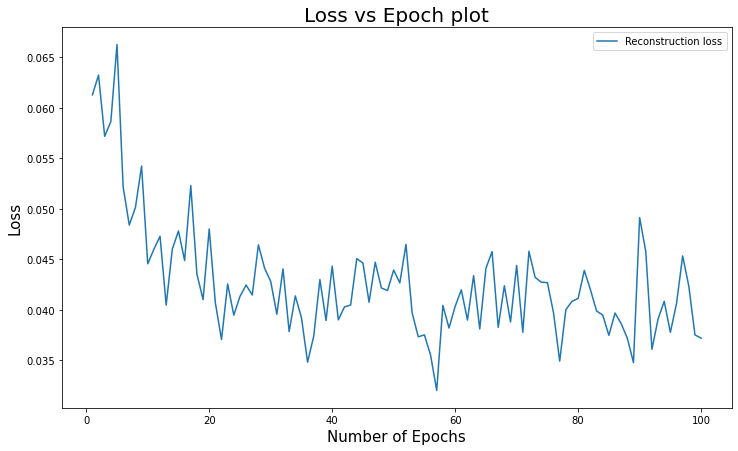

In [43]:
x = np.arange(1,101)
f=plt.figure()
f.set_figwidth(12)
f.set_figheight(7)

plt.title("Loss vs Epoch plot",fontsize=20)
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(x,r_l,label="Reconstruction loss")

plt.legend()

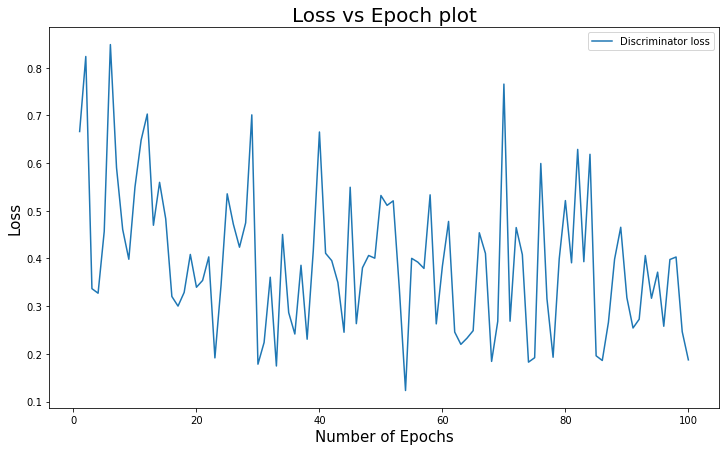

In [44]:
x = np.arange(1,101)
f=plt.figure()
f.set_figwidth(12)
f.set_figheight(7)

plt.title("Loss vs Epoch plot",fontsize=20)
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(x,D_l,label="Discriminator loss")
plt.legend()

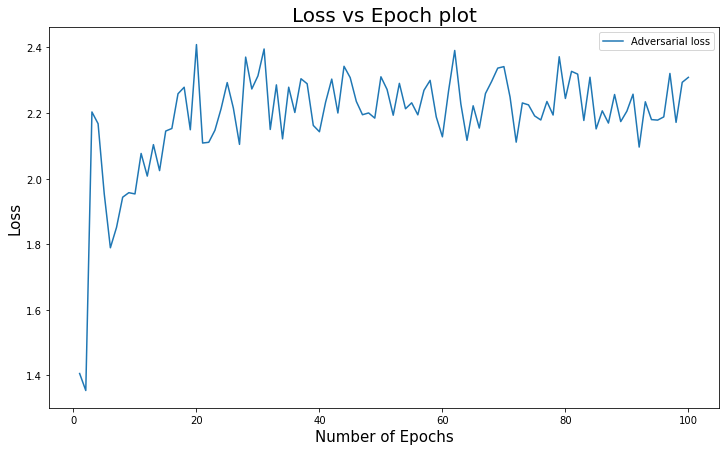

In [45]:
x = np.arange(1,101)
f=plt.figure()
f.set_figwidth(12)
f.set_figheight(7)

plt.title("Loss vs Epoch plot",fontsize=20)
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(x,A_l,label="Adversarial loss")
plt.legend()

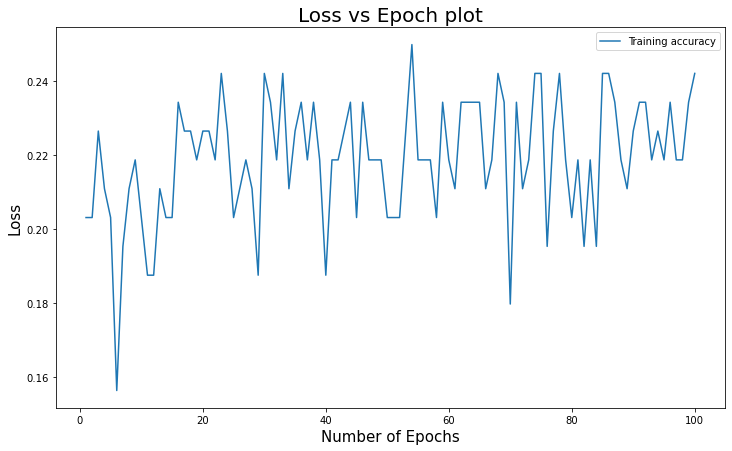

In [46]:
x = np.arange(1,101)
f=plt.figure()
f.set_figwidth(12)
f.set_figheight(7)

plt.title("Loss vs Epoch plot",fontsize=20)
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(x,tac,label="Training accuracy")
plt.legend()

In [ ]:
criterion = nn.CrossEntropyLoss() 
num_epochs2 = 50

train_loss2 = []
train_acc2 = []
for epoch in range(num_epochs2):
    
    running_loss = 0.0 
    running_corr = 0
        
    for i,data in enumerate(trainLoader):
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        optimizer2.zero_grad() 
        # Data feed-forward through the network
        outputs2 = net2(inputs)
        # Predicted class is the one with maximum probability
        preds2 = torch.argmax(outputs2,dim=1)
        # Finding the loss
        loss = criterion(outputs2, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds2==labels)    
        
    totalLoss2 = running_loss/(i+1)
    # Calculating gradients
    totalLoss2.backward()
    # Updating the model parameters
    # Updating the model parameters
    optimizer2.step()
        
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/60000
    
    
         
    train_loss2.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc2.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
       

In [26]:
r_l

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     